In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import torch, torch_geometric
# print("Torch:", torch.__version__)
# print("CUDA available:", torch.cuda.is_available())
# print("PyG:", torch_geometric.__version__)


In [ ]:
# !pip install -q torch_geometric
# !pip install -q class_resolver
# !pip3 install pymatting

In [168]:
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import torch
# import util
from PIL import Image
import matplotlib.pyplot as plt
from numpy import asarray
import tifffile as tiff
import torch.nn as nn
import torch.nn.functional as nnFn
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.manifold import TSNE
import random
from torch_geometric.nn import ARMAConv
import copy

In [ ]:
# fa_feature_path = "/home/snu/Downloads/Histogram_CN_FA_20bin_updated.npy"
# Histogram_feature_CN_FA_array = np.load(fa_feature_path, allow_pickle=True)

# # Load MCI features
# fa_feature_path = "/home/snu/Downloads/Histogram_MCI_FA_20bin_updated.npy"
# Histogram_feature_MCI_FA_array = np.load(fa_feature_path, allow_pickle=True)

# # Combine features and labels
# X = np.vstack([Histogram_feature_CN_FA_array, Histogram_feature_MCI_FA_array])
# y = np.hstack([
#     np.zeros(Histogram_feature_CN_FA_array.shape[0], dtype=np.int64),
#     np.ones(Histogram_feature_MCI_FA_array.shape[0], dtype=np.int64)
# ])
# np.random.seed(42)
# perm = np.random.permutation(X.shape[0])
# X = X[perm]
# y = y[perm]
# num_nodes, num_feats = X.shape
# print(f"Features: {X.shape}, Labels: {y.shape}")

Features: (300, 180), Labels: (300,)


In [169]:
fa_feature_path = "/home/snu/Downloads/Histogram_CN_FA_10bin.npy"
Histogram_feature_CN_FA_array = np.load(fa_feature_path, allow_pickle=True)

# Load MCI features
fa_feature_path = "/home/snu/Downloads/Histogram_MCI_FA_10bin.npy"
Histogram_feature_MCI_FA_array = np.load(fa_feature_path, allow_pickle=True)

# Combine features and labels
X = np.vstack([Histogram_feature_CN_FA_array, Histogram_feature_MCI_FA_array])
y = np.hstack([
    np.zeros(Histogram_feature_CN_FA_array.shape[0], dtype=np.int64),
    np.ones(Histogram_feature_MCI_FA_array.shape[0], dtype=np.int64)
])
np.random.seed(42)
perm = np.random.permutation(X.shape[0])
X = X[perm]
y = y[perm]
num_nodes, num_feats = X.shape
print(f"Features: {X.shape}, Labels: {y.shape}")

Features: (300, 90), Labels: (300,)


## 1 layer

In [170]:
def sim(h1, h2, tau = 0.2):
    z1 = nnFn.normalize(h1, dim=-1, p=2)
    z2 = nnFn.normalize(h2, dim=-1, p=2)
    return torch.mm(z1, z2.t()) / tau

def contrastive_loss_wo_cross_network(h1, h2, z):
    f = lambda x: torch.exp(x)
    intra_sim = f(sim(h1, h1))
    inter_sim = f(sim(h1, h2))
    return -torch.log(inter_sim.diag() /
                     (intra_sim.sum(dim=-1) + inter_sim.sum(dim=-1) - intra_sim.diag()))

def contrastive_loss_wo_cross_view(h1, h2, z):
    f = lambda x: torch.exp(x)
    cross_sim = f(sim(h1, z))
    return -torch.log(cross_sim.diag() / cross_sim.sum(dim=-1))

In [171]:
class MLP(nn.Module):
    def __init__(self, inp_size, outp_size, hidden_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(inp_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.PReLU(), # nn.ELU()
            nn.Dropout(0.3),
            nn.Linear(hidden_size, outp_size)
        )

    def forward(self, x):
        return self.net(x)

In [172]:
class ARMAEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, device, activ="ELU", num_stacks=1, num_layers=1):
        super(ARMAEncoder, self).__init__()
        self.device = device
        # Define all activation functions
        activations = {
            "SELU": nnFn.selu,
            "SiLU": nnFn.silu,
            "GELU": nnFn.gelu,
            "ELU": nnFn.elu,
            "RELU": nnFn.relu
        }
        # Get the activation function based on the input string
        self.act = activations.get(activ, nnFn.elu)

        self.arma = ARMAConv(
            in_channels=input_dim,
            out_channels=hidden_dim,
            num_stacks=num_stacks,   # number of parallel stacks
            num_layers=num_layers,   # depth per stack
            act=self.act,               # nonlinearity inside ARMA
            shared_weights=True,     # weight sharing across layers
            dropout=0.25             # ARMA-internal dropout
        )
        self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.mlp = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.arma(x, edge_index)
        x = self.dropout(x)
        x = self.batchnorm(x)
        logits = self.mlp(x)
        return logits

In [173]:
class EMA(): # Moving Average update

    def __init__(self, beta):
        super().__init__()
        self.beta = beta

    def update_average(self, old, new):
        # old: old model parameter
        # new: new model parameter
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

def update_moving_average(ema_updater, ma_model, current_model):
    for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
        old_weight, up_weight = ma_params.data, current_params.data
        ma_params.data = ema_updater.update_average(old_weight, up_weight)

In [174]:
class ARMA(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_clusters, device, activ, moving_average_decay=0.5, cut=True):
        super(ARMA, self).__init__()
        self.device = device
        self.num_clusters = num_clusters
        self.cut = cut
        self.beta = 0.6

        # Use ARMA encoder instead of GCN encoder
        self.online_encoder = ARMAEncoder(input_dim, hidden_dim, device, activ)
        self.target_encoder = copy.deepcopy(self.online_encoder)

        activations = {
            "SELU": nnFn.selu,
            "SiLU": nnFn.silu,
            "GELU": nnFn.gelu,
            "RELU": nnFn.relu
        }
        self.act = activations.get(activ, nnFn.elu)

        # Predictor head
        self.online_predictor = MLP(hidden_dim, num_clusters, hidden_dim)

        # Loss selection
        self.loss = self.cut_loss if cut else self.modularity_loss
        self.target_ema_updater = EMA(moving_average_decay)

    def reset_moving_average(self):
        del self.target_encoder
        self.target_encoder = None

    def update_ma(self):
        assert self.target_encoder is not None, 'target encoder has not been created yet'
        update_moving_average(self.target_ema_updater, self.target_encoder, self.online_encoder)

    def forward(self, data1, data2):
        x1 = self.online_encoder(data1)
        logits1 = self.online_predictor(x1)
        S1 = nnFn.softmax(logits1, dim=1)

        x2 = self.online_encoder(data2)
        logits2 = self.online_predictor(x2)
        S2 = nnFn.softmax(logits2, dim=1)

        with torch.no_grad():
            target_proj_one = self.target_encoder(data1).detach()
            target_proj_two = self.target_encoder(data2).detach()

        l1 = self.beta * contrastive_loss_wo_cross_network(x1, x2, target_proj_two) + \
             (1.0 - self.beta) * contrastive_loss_wo_cross_view(x1, x2, target_proj_two)

        l2 = self.beta * contrastive_loss_wo_cross_network(x2, x1, target_proj_one) + \
             (1.0 - self.beta) * contrastive_loss_wo_cross_view(x2, x1, target_proj_one)

        return S1, S2, logits1, logits2, l1, l2

    def modularity_loss(self, A, S):
        C = nnFn.softmax(S, dim=1)
        d = torch.sum(A, dim=1)
        m = torch.sum(A)
        B = A - torch.ger(d, d) / (2 * m)

        I_S = torch.eye(self.num_clusters, device=self.device)
        # k = torch.norm(I_S)
        k = torch.tensor(self.num_clusters, device=self.device, dtype=torch.float32)
        n = S.shape[0]

        modularity_term = (-1 / (2 * m)) * torch.trace(torch.mm(torch.mm(C.t(), B), C))
        collapse_reg_term = (torch.sqrt(k) / n) * torch.norm(torch.sum(C, dim=0), p='fro') - 1

        return modularity_term + collapse_reg_term

    def cut_loss(self, A, S):
        S = nnFn.softmax(S, dim=1)
        A_pool = torch.matmul(torch.matmul(A, S).t(), S)
        num = torch.trace(A_pool)

        D = torch.diag(torch.sum(A, dim=-1))
        D_pooled = torch.matmul(torch.matmul(D, S).t(), S)
        den = torch.trace(D_pooled)
        mincut_loss = -(num / den)

        St_S = torch.matmul(S.t(), S)
        I_S = torch.eye(self.num_clusters, device=self.device)
        ortho_loss = torch.norm(St_S / torch.norm(St_S) - I_S / torch.norm(I_S))

        return mincut_loss + ortho_loss

In [175]:
def create_adj(features, cut, alpha=1.0):
    """Return a dense W0 matrix (only once), as you originally used for A1 / unsup loss.
       We still create the dense matrix once, but all augmentations below work with edge_index.
    """
    F_norm = features / np.linalg.norm(features, axis=1, keepdims=True)
    W = np.dot(F_norm, F_norm.T)

    if cut == 0:
        W = np.where(W >= alpha, 1, 0).astype(np.float32)
        W = (W / W.max()).astype(np.float32)
    else:
        W = (W * (W >= alpha)).astype(np.float32)
    return W

In [176]:
def edge_index_from_dense(W):
    """Return edge_index as numpy array shape (2, E) and edge_weight vector."""
    rows, cols = np.nonzero(W > 0)
    edge_index = np.vstack([rows, cols]).astype(np.int64)
    edge_weight = W[rows, cols].astype(np.float32)
    return edge_index, edge_weight

In [177]:
def build_adj_list(edge_index_np, num_nodes):
    """Build adjacency list: list of neighbor arrays for each node (numpy)."""
    adj = [[] for _ in range(num_nodes)]
    src = edge_index_np[0]
    dst = edge_index_np[1]
    for s, d in zip(src, dst):
        adj[s].append(d)
    # convert to numpy arrays for speed
    adj = [np.array(neis, dtype=np.int64) if len(neis) > 0 else np.array([], dtype=np.int64) for neis in adj]
    return adj

In [178]:
def aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=None):
    """Randomly drop edges from edge_index. Returns new edge_index (2 x E') and edge_weight placeholder."""
    rng = np.random.default_rng(seed)
    E = edge_index_np.shape[1]
    keep_mask = rng.random(E) >= drop_percent
    new_edge_index = edge_index_np[:, keep_mask]
    return new_edge_index

In [179]:
def aug_subgraph_edge_index(features_np, edge_index_np, adj_list, drop_percent=0.2, seed=None):
    """
    Sample a subgraph by selecting s_node_num nodes via neighbor expansion (BFS-like),
    then return (sub_features, sub_edge_index) with node ids remapped to [0..s-1].
    """
    rng = np.random.default_rng(seed)
    num_nodes = features_np.shape[0]
    s_node_num = int(num_nodes * (1 - drop_percent))
    if s_node_num < 1:
        s_node_num = 1

    # choose a random center node
    center_node = int(rng.integers(0, num_nodes))
    sub_nodes = [center_node]
    front_idx = 0

    # BFS-like expansion using adjacency list until we reach s_node_num
    while len(sub_nodes) < s_node_num and front_idx < len(sub_nodes):
        cur = sub_nodes[front_idx]
        neighbors = adj_list[cur]
        if neighbors.size > 0:
            # shuffle neighbors and try to add new ones
            nbrs_shuffled = neighbors.copy()
            rng.shuffle(nbrs_shuffled)
            for nb in nbrs_shuffled:
                if nb not in sub_nodes:
                    sub_nodes.append(int(nb))
                    if len(sub_nodes) >= s_node_num:
                        break
        front_idx += 1
        # if BFS stalls (no new neighbors), add random nodes
        if front_idx >= len(sub_nodes) and len(sub_nodes) < s_node_num:
            remaining = [n for n in range(num_nodes) if n not in sub_nodes]
            if not remaining:
                break
            add = int(rng.choice(remaining))
            sub_nodes.append(add)

    sub_nodes = sorted(set(sub_nodes))
    node_map = {old: new for new, old in enumerate(sub_nodes)}

    # induce edges that have both ends in sub_nodes
    src = edge_index_np[0]
    dst = edge_index_np[1]
    mask_src_in = np.isin(src, sub_nodes)
    mask_dst_in = np.isin(dst, sub_nodes)
    mask = mask_src_in & mask_dst_in
    sel_src = src[mask]
    sel_dst = dst[mask]
    # remap
    remapped_src = np.array([node_map[int(s)] for s in sel_src], dtype=np.int64)
    remapped_dst = np.array([node_map[int(d)] for d in sel_dst], dtype=np.int64)
    new_edge_index = np.vstack([remapped_src, remapped_dst])
    # sub features
    sub_features = features_np[sub_nodes, :].astype(np.float32)
    return sub_features, new_edge_index

In [180]:
def load_data_from_edge_index(node_feats_np, edge_index_np, device):
    """Return PyG Data with torch tensors. edge_index_np is (2, E) numpy."""
    node_feats = torch.from_numpy(node_feats_np).float()
    edge_index = torch.from_numpy(edge_index_np.astype(np.int64)).long()
    return node_feats, edge_index

# Data Loading and preprocessing

In [181]:
print("CN Shape:", Histogram_feature_CN_FA_array.shape)
print("MCI Shape:",Histogram_feature_MCI_FA_array.shape)

CN Shape: (133, 90)
MCI Shape: (167, 90)


In [182]:
features = X
#features = np.concatenate((Histogram_feature_CN_FA_array, Histogram_feature_MCI_FA_array), axis=0)
features = features.astype(np.float32)
print(features.shape, features.dtype)

(300, 90) float32


In [ ]:
# # Required Parameters
# cut = 0  # Consider n-cut loss OR Modularity loss
# alpha = 0.95 #0.7 # Edge creation Threshold
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# feats_dim = 180  # 20-bin
# K = 2  # Number of clusters
# epoch = [2500, 60, 100]  # Training epochs for different phases

# # Define all activation functions to test
# define_activations = ["SELU", "SiLU", "GELU", "ELU", "RELU"]
# activ = "ELU"

In [183]:
# Required Parameters
cut = 0  # Consider n-cut loss OR Modularity loss
alpha = 0.92 #0.7 # Edge creation Threshold
device = 'cuda' if torch.cuda.is_available() else 'cpu'
feats_dim = 90  # 20-bin
K = 2  # Number of clusters
epoch = [2500, 60, 100]  # Training epochs for different phases

# Define all activation functions to test
define_activations = ["SELU", "SiLU", "GELU", "ELU", "RELU"]
activ = "ELU"

In [184]:
print(features.shape)

(300, 90)


In [185]:
F_norm = features / np.linalg.norm(features, axis=1, keepdims=True)
W = np.dot(F_norm, F_norm.T)
print(np.array(np.nonzero(W>0.6)).shape)

(2, 89360)


In [186]:
F_norm = features / np.linalg.norm(features, axis=1, keepdims=True)
W = np.dot(F_norm, F_norm.T)
print(W)

[[0.99999994 0.94718623 0.94407254 ... 0.9205637  0.9296568  0.932004  ]
 [0.94718623 1.0000001  0.94885916 ... 0.916886   0.95113266 0.9353091 ]
 [0.94407254 0.94885916 0.9999999  ... 0.91284966 0.91930676 0.9265799 ]
 ...
 [0.9205637  0.916886   0.91284966 ... 1.0000001  0.9007198  0.9507939 ]
 [0.9296568  0.95113266 0.91930676 ... 0.9007198  1.0000001  0.93976885]
 [0.932004   0.9353091  0.9265799  ... 0.9507939  0.93976885 0.9999998 ]]


# Fully connected directed graph
# ONLY single directed edge between any two nodes

In [ ]:
# num_nodes = F.shape[0]
# edge_index = torch.combinations(torch.arange(num_nodes), r=2).T
# def create_adjacency_matrix(edge_index, num_nodes):
#     adj = torch.zeros((num_nodes, num_nodes))
#     adj[edge_index[0], edge_index[1]] = 1
#     return adj

# W = create_adjacency_matrix(edge_index, num_nodes).numpy()
# print("W Shape= " , W.shape)

In [187]:
W0 = create_adj(features, cut, alpha)  # shape (N, N) dense
A1 = torch.from_numpy(W0).float().to(device)

edge_index_np, edge_weight_np = edge_index_from_dense(W0)  # numpy edge_index (2, E)
num_nodes = features.shape[0]
adj_list = build_adj_list(edge_index_np, num_nodes)  # adjacency list for fast subgraph sampling

# convert features to numpy (we'll slice them in augmentations)
features_np = features.copy()

# Build initial Data object (full graph)
node_feats_full, edge_index_full = load_data_from_edge_index(features_np, edge_index_np, device)
data0 = Data(x=node_feats_full.to(device), edge_index=edge_index_full.to(device))
print("Data0:", data0)

Data0: Data(x=[300, 90], edge_index=[2, 38252])


# Model initialization

## Contrastive Loss

In [ ]:
from torch.optim.lr_scheduler import StepLR
from torch.optim import AdamW
import torch.nn as nn

model = ARMA(feats_dim, 256, K, device, activ, cut=cut).to(device)
optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
scheduler = StepLR(optimizer, step_size=200, gamma=0.5)
criterion = nn.CrossEntropyLoss()

num_epochs = 5000
lambda_contrastive = 0.3
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
for epoch in range(num_epochs):
    # --- Augmentations using edge_index or adjacency list (fast, sparse) ---
    # 1) Random edge drop on edge_index
    W_aug1_edge_index = aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=epoch)

    # 2) Subgraph via adjacency list (returns sub_features and sub_edge_index)
    W_aug2_edge_index = aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=epoch + 999)
    features_aug2 = features_np.copy()

    # 3) Feature augmentations (keep these as numpy operations)
    # Feature dropout (column-wise)
    rng = np.random.default_rng(epoch)
    mask = rng.random(features_np.shape) >= 0.2
    features_aug1 = (features_np * mask.astype(np.float32))

    # Feature cell dropout (random cell zeroing)
    aug_feat2 = features_np.copy()
    num_nodes_local, feat_dim = aug_feat2.shape
    drop_feat_num = int(num_nodes_local * feat_dim * 0.2)
    # random positions to zero
    flat_idx = rng.choice(num_nodes_local * feat_dim, size=drop_feat_num, replace=False)
    rows = (flat_idx // feat_dim)
    cols = (flat_idx % feat_dim)
    aug_feat2[rows, cols] = 0.0
    features_aug2_feat = aug_feat2.astype(np.float32)

    # --- Build PyG Data objects for the two views ---
    # view1: features_aug1 with W_aug1_edge_index
    node_feats1, edge_index1 = load_data_from_edge_index(features_aug1, W_aug1_edge_index, device)
    data1 = Data(x=node_feats1.to(device), edge_index=edge_index1.to(device))

    # view2: features_aug2 (from subgraph) and its edge_index
    node_feats2, edge_index2 = load_data_from_edge_index(features_aug2, W_aug2_edge_index, device)
    data2 = Data(x=node_feats2.to(device), edge_index=edge_index2.to(device))

    # --- Training step ---
    model.train()
    optimizer.zero_grad()

    S1, S2, logits1, logits2, l1, l2 = model(data1, data2)

    unsup_loss = model.loss(A1, logits1)
    cont_loss = ((l1 + l2) / 2).mean()
    total_loss = unsup_loss + lambda_contrastive * cont_loss

    total_loss.backward()
    optimizer.step()
    scheduler.step()
    model.update_ma()

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Total: {total_loss.item():.4f} | Unsup: {unsup_loss.item():.4f} | Cont: {cont_loss.item():.4f}")

Epoch 0 | Total: 1.5483 | Unsup: -0.1258 | Cont: 5.5804
Epoch 100 | Total: 1.1048 | Unsup: -0.2774 | Cont: 4.6073
Epoch 200 | Total: 1.0147 | Unsup: -0.2860 | Cont: 4.3359
Epoch 300 | Total: 0.9836 | Unsup: -0.2886 | Cont: 4.2406
Epoch 400 | Total: 0.9545 | Unsup: -0.2864 | Cont: 4.1363
Epoch 500 | Total: 0.9460 | Unsup: -0.2889 | Cont: 4.1164
Epoch 600 | Total: 0.9455 | Unsup: -0.2905 | Cont: 4.1200
Epoch 700 | Total: 0.9398 | Unsup: -0.2887 | Cont: 4.0950
Epoch 800 | Total: 0.9332 | Unsup: -0.2902 | Cont: 4.0778
Epoch 900 | Total: 0.9322 | Unsup: -0.2906 | Cont: 4.0761
Epoch 1000 | Total: 0.9251 | Unsup: -0.2881 | Cont: 4.0440
Epoch 1100 | Total: 0.9166 | Unsup: -0.2902 | Cont: 4.0225
Epoch 1200 | Total: 0.9265 | Unsup: -0.2913 | Cont: 4.0591
Epoch 1300 | Total: 0.9223 | Unsup: -0.2920 | Cont: 4.0475
Epoch 1400 | Total: 0.9205 | Unsup: -0.2910 | Cont: 4.0381
Epoch 1500 | Total: 0.9029 | Unsup: -0.2898 | Cont: 3.9756
Epoch 1600 | Total: 0.9200 | Unsup: -0.2910 | Cont: 4.0366
Epoch 170

In [ ]:
model.eval()
with torch.no_grad():
        S1, _, logits1,_,_,_ = model(data0, data0)
        y_pred = torch.argmax(logits1, dim=1).cpu().numpy()
        y_pred_proba = nnFn.softmax(logits1, dim=1).cpu().numpy()
        print(y_pred)
        print(y_pred_proba.max(axis=-1))

[1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1
 0 0 0 1 0 1 0 0 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 1 1
 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0 0 1 1 1 1 0 1 1 0
 0 0 1 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 1 1 1 1 0 1
 1 0 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1
 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 0
 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1
 0 0 0 0 0 0 1 0 1 1 0 0 0 1 1 1 1 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1
 0 0 0 0]
[0.9999274  0.99949217 0.99999464 0.99990404 1.         0.99971014
 0.9999838  0.6432374  0.99999905 0.9999999  1.         0.98198676
 0.99997187 0.96750736 0.9999999  0.9999999  1.         0.99149925
 0.99999464 0.99999905 0.97793293 0.9999925  0.99999785 0.9971027
 0.80844694 0.9967385  1.         0.96989506 0.99997723 0.9996778
 0.9812215  1.         0.9934355  0.9958497  0.9994223  0

In [ ]:
acc_score = accuracy_score(y, y_pred)
acc_score_inverted = accuracy_score(y, 1 - y_pred)

print("Accuracy Score:", acc_score)
print("Accuracy Score Inverted:", acc_score_inverted)

if acc_score_inverted > acc_score:
    acc_score = acc_score_inverted
    y_pred = 1 - y_pred

prec_score = precision_score(y, y_pred)
rec_score = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
log_loss_value = log_loss(y, y_pred_proba)

print("Precision Score:", prec_score)
print("Recall Score:", rec_score)
print("F1 Score:", f1)
print("Log Loss:", log_loss_value)

Accuracy Score: 0.7466666666666667
Accuracy Score Inverted: 0.25333333333333335
Precision Score: 0.8013245033112583
Recall Score: 0.7245508982035929
F1 Score: 0.7610062893081762
Log Loss: 2.375213014703639


In [188]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as nnFn
from torch.optim.lr_scheduler import StepLR
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from torch_geometric.data import Data
import random
import scipy.sparse as sp
from copy import deepcopy
from typing import Dict, List

num_runs = 10
num_epochs = 5000
lr = 1e-4
weight_decay = 1e-4
lambda_list = [0.3]
base_seed = 42
eval_every_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


all_results: List[Dict] = []

for lam in lambda_list:
    print(f"\n================ LAMBDA = {lam} ================\n")


    acc_scores: List[float] = []
    prec_scores: List[float] = []
    rec_scores: List[float] = []
    f1_scores: List[float] = []
    log_losses: List[float] = []

    for run in range(num_runs):

        seed = base_seed + run
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

        print(f"\n--- Run {run+1}/{num_runs} (seed={seed}) ---")


        model = ARMA(feats_dim, 256, K, device, activ, cut).to(device)

        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = StepLR(optimizer, step_size=200, gamma=0.5)

        lambda_contrastive = lam

        per_run_accs: List[float] = []
        per_run_precs: List[float] = []
        per_run_recs: List[float] = []
        per_run_f1s: List[float] = []
        per_run_log_losses: List[float] = []

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            W_aug1_edge_index = aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=epoch)

            W_aug2_edge_index = aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=epoch + 999)

            rng = np.random.default_rng(seed + epoch)
            mask = rng.random(features_np.shape) >= 0.2
            features_aug1 = (features_np * mask.astype(np.float32))

            aug_feat2 = features_np.copy()
            num_nodes_local, feat_dim = aug_feat2.shape
            drop_feat_num = int(num_nodes_local * feat_dim * 0.2)
            if drop_feat_num > 0:
                flat_idx = rng.choice(num_nodes_local * feat_dim, size=drop_feat_num, replace=False)
                rows = (flat_idx // feat_dim)
                cols = (flat_idx % feat_dim)
                aug_feat2[rows, cols] = 0.0
            features_aug2 = aug_feat2.astype(np.float32)

            node_feats1, edge_index1 = load_data_from_edge_index(features_aug1, W_aug1_edge_index, device)
            data1 = Data(x=node_feats1.to(device), edge_index=edge_index1.to(device))

            node_feats2, edge_index2 = load_data_from_edge_index(features_aug2, W_aug2_edge_index, device)
            data2 = Data(x=node_feats2.to(device), edge_index=edge_index2.to(device))

            S1, S2, logits1, logits2, l1, l2 = model(data1, data2)

            unsup_loss = model.loss(A1, logits1)

            cont_loss = 0.5 * (l1 + l2).mean()
            total_loss = unsup_loss + lambda_contrastive * cont_loss

            total_loss.backward()
            optimizer.step()
            scheduler.step()


            if hasattr(model, "update_ma"):
                model.update_ma()

            if (eval_every_epochs is not None and epoch % eval_every_epochs == 0) or (epoch == num_epochs - 1):
                print(f"Epoch {epoch} | Total: {total_loss.item():.4f} | Unsup: {unsup_loss.item():.4f} | Cont: {cont_loss.item():.4f}")

                if 'data0' in globals():
                    model.eval()
                    with torch.no_grad():
                        # Using data0 twice (as in your original script)
                        S1_eval, _, logits_eval, _, _, _ = model(data0, data0)
                        y_pred = torch.argmax(logits_eval, dim=1).cpu().numpy()
                        y_pred_proba = nnFn.softmax(logits_eval, dim=1).cpu().numpy()

                        y_true = y.cpu().numpy() if isinstance(y, torch.Tensor) else y

                        acc_score = accuracy_score(y_true, y_pred)
                        acc_score_inverted = accuracy_score(y_true, 1 - y_pred)
                        if acc_score_inverted > acc_score:
                            acc_score = acc_score_inverted
                            y_pred = 1 - y_pred

                        prec_score = precision_score(y_true, y_pred, zero_division=0)
                        rec_score = recall_score(y_true, y_pred, zero_division=0)
                        f1 = f1_score(y_true, y_pred, zero_division=0)
                        try:
                            log_loss_value = log_loss(y_true, y_pred_proba)
                        except ValueError:

                            log_loss_value = float("nan")

                        per_run_accs.append(acc_score)
                        per_run_precs.append(prec_score)
                        per_run_recs.append(rec_score)
                        per_run_f1s.append(f1)
                        per_run_log_losses.append(log_loss_value)

        if len(per_run_accs) == 0 and 'data0' in globals():
            model.eval()
            with torch.no_grad():
                S1_eval, _, logits_eval, _, _, _ = model(data0, data0)
                y_pred = torch.argmax(logits_eval, dim=1).cpu().numpy()
                y_pred_proba = nnFn.softmax(logits_eval, dim=1).cpu().numpy()
                y_true = y.cpu().numpy() if isinstance(y, torch.Tensor) else y

                acc_score = accuracy_score(y_true, y_pred)
                acc_score_inverted = accuracy_score(y_true, 1 - y_pred)
                if acc_score_inverted > acc_score:
                    acc_score = acc_score_inverted
                    y_pred = 1 - y_pred

                prec_score = precision_score(y_true, y_pred, zero_division=0)
                rec_score = recall_score(y_true, y_pred, zero_division=0)
                f1 = f1_score(y_true, y_pred, zero_division=0)
                try:
                    log_loss_value = log_loss(y_true, y_pred_proba)
                except ValueError:
                    log_loss_value = float("nan")

                per_run_accs.append(acc_score)
                per_run_precs.append(prec_score)
                per_run_recs.append(rec_score)
                per_run_f1s.append(f1)
                per_run_log_losses.append(log_loss_value)

        run_acc = float(np.mean(per_run_accs)) if len(per_run_accs) > 0 else float('nan')
        run_prec = float(np.mean(per_run_precs)) if len(per_run_precs) > 0 else float('nan')
        run_rec = float(np.mean(per_run_recs)) if len(per_run_recs) > 0 else float('nan')
        run_f1 = float(np.mean(per_run_f1s)) if len(per_run_f1s) > 0 else float('nan')
        run_logloss = float(np.nanmean(per_run_log_losses)) if len(per_run_log_losses) > 0 else float('nan')

        acc_scores.append(run_acc)
        prec_scores.append(run_prec)
        rec_scores.append(run_rec)
        f1_scores.append(run_f1)
        log_losses.append(run_logloss)

        print(f"Run {run+1} summary -- Acc: {run_acc:.4f}, Prec: {run_prec:.4f}, Rec: {run_rec:.4f}, F1: {run_f1:.4f}, LogLoss: {run_logloss:.4f}")

    lambda_results = {
        "lambda": lam,
        "accuracy": (float(np.nanmean(acc_scores)), float(np.nanstd(acc_scores))),
        "precision": (float(np.nanmean(prec_scores)), float(np.nanstd(prec_scores))),
        "recall": (float(np.nanmean(rec_scores)), float(np.nanstd(rec_scores))),
        "f1": (float(np.nanmean(f1_scores)), float(np.nanstd(f1_scores))),
        "log_loss": (float(np.nanmean(log_losses)), float(np.nanstd(log_losses)))
    }
    all_results.append(lambda_results)

    print(f"\n--- RESULTS FOR LAMBDA = {lam} ---")
    print(f"Accuracy: {lambda_results['accuracy'][0]:.4f} ± {lambda_results['accuracy'][1]:.4f}")
    print(f"Precision: {lambda_results['precision'][0]:.4f} ± {lambda_results['precision'][1]:.4f}")
    print(f"Recall: {lambda_results['recall'][0]:.4f} ± {lambda_results['recall'][1]:.4f}")
    print(f"F1 Score: {lambda_results['f1'][0]:.4f} ± {lambda_results['f1'][1]:.4f}")
    print(f"Log Loss: {lambda_results['log_loss'][0]:.4f} ± {lambda_results['log_loss'][1]:.4f}")

print("\n================ FINAL SUMMARY FOR ALL LAMBDAS ================\n")
print(f"{'Lambda':>8} | {'Accuracy':>18} | {'Precision':>18} | {'Recall':>18} | {'F1 Score':>18} | {'Log Loss':>18}")
print("-" * 108)
for res in all_results:
    print(f"{res['lambda']:>8} | "
          f"{res['accuracy'][0]:.4f} ± {res['accuracy'][1]:.4f} | "
          f"{res['precision'][0]:.4f} ± {res['precision'][1]:.4f} | "
          f"{res['recall'][0]:.4f} ± {res['recall'][1]:.4f} | "
          f"{res['f1'][0]:.4f} ± {res['f1'][1]:.4f} | "
          f"{res['log_loss'][0]:.4f} ± {res['log_loss'][1]:.4f}")



================ LAMBDA = 0.3 ================


--- Run 1/10 (seed=42) ---
Epoch 0 | Total: 1.5097 | Unsup: -0.2422 | Cont: 5.8397
Epoch 100 | Total: 0.8746 | Unsup: -0.6979 | Cont: 5.2419
Epoch 200 | Total: 0.7675 | Unsup: -0.7153 | Cont: 4.9424
Epoch 300 | Total: 0.7051 | Unsup: -0.7339 | Cont: 4.7968
Epoch 400 | Total: 0.6730 | Unsup: -0.7348 | Cont: 4.6927
Epoch 500 | Total: 0.6717 | Unsup: -0.7320 | Cont: 4.6788
Epoch 600 | Total: 0.6531 | Unsup: -0.7322 | Cont: 4.6179
Epoch 700 | Total: 0.6572 | Unsup: -0.7364 | Cont: 4.6454
Epoch 800 | Total: 0.6476 | Unsup: -0.7366 | Cont: 4.6137
Epoch 900 | Total: 0.6565 | Unsup: -0.7345 | Cont: 4.6368
Epoch 1000 | Total: 0.6421 | Unsup: -0.7386 | Cont: 4.6024
Epoch 1100 | Total: 0.6361 | Unsup: -0.7405 | Cont: 4.5883
Epoch 1200 | Total: 0.6314 | Unsup: -0.7390 | Cont: 4.5680
Epoch 1300 | Total: 0.6557 | Unsup: -0.7322 | Cont: 4.6263
Epoch 1400 | Total: 0.6366 | Unsup: -0.7396 | Cont: 4.5875
Epoch 1500 | Total: 0.6379 | Unsup: -0.7401 | Cont

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as nnFn
from torch.optim.lr_scheduler import StepLR
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from torch_geometric.data import Data
import random
import scipy.sparse as sp
from copy import deepcopy
from typing import Dict, List

num_runs = 10
num_epochs = 5000
lr = 1e-4
weight_decay = 1e-4
lambda_list = [0.001, 0.01, 0.3, 0.9, 2]
base_seed = 42
eval_every_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


all_results: List[Dict] = []

for lam in lambda_list:
    print(f"\n================ LAMBDA = {lam} ================\n")


    acc_scores: List[float] = []
    prec_scores: List[float] = []
    rec_scores: List[float] = []
    f1_scores: List[float] = []
    log_losses: List[float] = []

    for run in range(num_runs):

        seed = base_seed + run
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

        print(f"\n--- Run {run+1}/{num_runs} (seed={seed}) ---")


        model = ARMA(feats_dim, 256, K, device, activ, cut).to(device)

        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = StepLR(optimizer, step_size=200, gamma=0.5)

        lambda_contrastive = lam

        per_run_accs: List[float] = []
        per_run_precs: List[float] = []
        per_run_recs: List[float] = []
        per_run_f1s: List[float] = []
        per_run_log_losses: List[float] = []

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            W_aug1_edge_index = aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=epoch)

            W_aug2_edge_index = aug_random_edge_edge_index(edge_index_np, drop_percent=0.2, seed=epoch + 999)

            rng = np.random.default_rng(seed + epoch)
            mask = rng.random(features_np.shape) >= 0.2
            features_aug1 = (features_np * mask.astype(np.float32))

            aug_feat2 = features_np.copy()
            num_nodes_local, feat_dim = aug_feat2.shape
            drop_feat_num = int(num_nodes_local * feat_dim * 0.2)
            if drop_feat_num > 0:
                flat_idx = rng.choice(num_nodes_local * feat_dim, size=drop_feat_num, replace=False)
                rows = (flat_idx // feat_dim)
                cols = (flat_idx % feat_dim)
                aug_feat2[rows, cols] = 0.0
            features_aug2 = aug_feat2.astype(np.float32)

            node_feats1, edge_index1 = load_data_from_edge_index(features_aug1, W_aug1_edge_index, device)
            data1 = Data(x=node_feats1.to(device), edge_index=edge_index1.to(device))

            node_feats2, edge_index2 = load_data_from_edge_index(features_aug2, W_aug2_edge_index, device)
            data2 = Data(x=node_feats2.to(device), edge_index=edge_index2.to(device))

            S1, S2, logits1, logits2, l1, l2 = model(data1, data2)

            unsup_loss = model.loss(A1, logits1)

            cont_loss = 0.5 * (l1 + l2).mean()
            total_loss = unsup_loss + lambda_contrastive * cont_loss

            total_loss.backward()
            optimizer.step()
            scheduler.step()


            if hasattr(model, "update_ma"):
                model.update_ma()

            if (eval_every_epochs is not None and epoch % eval_every_epochs == 0) or (epoch == num_epochs - 1):
                print(f"Epoch {epoch} | Total: {total_loss.item():.4f} | Unsup: {unsup_loss.item():.4f} | Cont: {cont_loss.item():.4f}")

                if 'data0' in globals():
                    model.eval()
                    with torch.no_grad():
                        # Using data0 twice (as in your original script)
                        S1_eval, _, logits_eval, _, _, _ = model(data0, data0)
                        y_pred = torch.argmax(logits_eval, dim=1).cpu().numpy()
                        y_pred_proba = nnFn.softmax(logits_eval, dim=1).cpu().numpy()

                        y_true = y.cpu().numpy() if isinstance(y, torch.Tensor) else y

                        acc_score = accuracy_score(y_true, y_pred)
                        acc_score_inverted = accuracy_score(y_true, 1 - y_pred)
                        if acc_score_inverted > acc_score:
                            acc_score = acc_score_inverted
                            y_pred = 1 - y_pred

                        prec_score = precision_score(y_true, y_pred, zero_division=0)
                        rec_score = recall_score(y_true, y_pred, zero_division=0)
                        f1 = f1_score(y_true, y_pred, zero_division=0)
                        try:
                            log_loss_value = log_loss(y_true, y_pred_proba)
                        except ValueError:

                            log_loss_value = float("nan")

                        per_run_accs.append(acc_score)
                        per_run_precs.append(prec_score)
                        per_run_recs.append(rec_score)
                        per_run_f1s.append(f1)
                        per_run_log_losses.append(log_loss_value)

        if len(per_run_accs) == 0 and 'data0' in globals():
            model.eval()
            with torch.no_grad():
                S1_eval, _, logits_eval, _, _, _ = model(data0, data0)
                y_pred = torch.argmax(logits_eval, dim=1).cpu().numpy()
                y_pred_proba = nnFn.softmax(logits_eval, dim=1).cpu().numpy()
                y_true = y.cpu().numpy() if isinstance(y, torch.Tensor) else y

                acc_score = accuracy_score(y_true, y_pred)
                acc_score_inverted = accuracy_score(y_true, 1 - y_pred)
                if acc_score_inverted > acc_score:
                    acc_score = acc_score_inverted
                    y_pred = 1 - y_pred

                prec_score = precision_score(y_true, y_pred, zero_division=0)
                rec_score = recall_score(y_true, y_pred, zero_division=0)
                f1 = f1_score(y_true, y_pred, zero_division=0)
                try:
                    log_loss_value = log_loss(y_true, y_pred_proba)
                except ValueError:
                    log_loss_value = float("nan")

                per_run_accs.append(acc_score)
                per_run_precs.append(prec_score)
                per_run_recs.append(rec_score)
                per_run_f1s.append(f1)
                per_run_log_losses.append(log_loss_value)

        run_acc = float(np.mean(per_run_accs)) if len(per_run_accs) > 0 else float('nan')
        run_prec = float(np.mean(per_run_precs)) if len(per_run_precs) > 0 else float('nan')
        run_rec = float(np.mean(per_run_recs)) if len(per_run_recs) > 0 else float('nan')
        run_f1 = float(np.mean(per_run_f1s)) if len(per_run_f1s) > 0 else float('nan')
        run_logloss = float(np.nanmean(per_run_log_losses)) if len(per_run_log_losses) > 0 else float('nan')

        acc_scores.append(run_acc)
        prec_scores.append(run_prec)
        rec_scores.append(run_rec)
        f1_scores.append(run_f1)
        log_losses.append(run_logloss)

        print(f"Run {run+1} summary -- Acc: {run_acc:.4f}, Prec: {run_prec:.4f}, Rec: {run_rec:.4f}, F1: {run_f1:.4f}, LogLoss: {run_logloss:.4f}")

    lambda_results = {
        "lambda": lam,
        "accuracy": (float(np.nanmean(acc_scores)), float(np.nanstd(acc_scores))),
        "precision": (float(np.nanmean(prec_scores)), float(np.nanstd(prec_scores))),
        "recall": (float(np.nanmean(rec_scores)), float(np.nanstd(rec_scores))),
        "f1": (float(np.nanmean(f1_scores)), float(np.nanstd(f1_scores))),
        "log_loss": (float(np.nanmean(log_losses)), float(np.nanstd(log_losses)))
    }
    all_results.append(lambda_results)

    print(f"\n--- RESULTS FOR LAMBDA = {lam} ---")
    print(f"Accuracy: {lambda_results['accuracy'][0]:.4f} ± {lambda_results['accuracy'][1]:.4f}")
    print(f"Precision: {lambda_results['precision'][0]:.4f} ± {lambda_results['precision'][1]:.4f}")
    print(f"Recall: {lambda_results['recall'][0]:.4f} ± {lambda_results['recall'][1]:.4f}")
    print(f"F1 Score: {lambda_results['f1'][0]:.4f} ± {lambda_results['f1'][1]:.4f}")
    print(f"Log Loss: {lambda_results['log_loss'][0]:.4f} ± {lambda_results['log_loss'][1]:.4f}")

print("\n================ FINAL SUMMARY FOR ALL LAMBDAS ================\n")
print(f"{'Lambda':>8} | {'Accuracy':>18} | {'Precision':>18} | {'Recall':>18} | {'F1 Score':>18} | {'Log Loss':>18}")
print("-" * 108)
for res in all_results:
    print(f"{res['lambda']:>8} | "
          f"{res['accuracy'][0]:.4f} ± {res['accuracy'][1]:.4f} | "
          f"{res['precision'][0]:.4f} ± {res['precision'][1]:.4f} | "
          f"{res['recall'][0]:.4f} ± {res['recall'][1]:.4f} | "
          f"{res['f1'][0]:.4f} ± {res['f1'][1]:.4f} | "
          f"{res['log_loss'][0]:.4f} ± {res['log_loss'][1]:.4f}")



================ LAMBDA = 0.001 ================


--- Run 1/10 (seed=42) ---
Epoch 0 | Total: -0.2303 | Unsup: -0.2360 | Cont: 5.7082
Epoch 100 | Total: -0.7639 | Unsup: -0.7692 | Cont: 5.2716
Epoch 200 | Total: -0.7959 | Unsup: -0.8011 | Cont: 5.2345
Epoch 300 | Total: -0.8080 | Unsup: -0.8132 | Cont: 5.2061
Epoch 400 | Total: -0.8062 | Unsup: -0.8113 | Cont: 5.1539
Epoch 500 | Total: -0.8146 | Unsup: -0.8198 | Cont: 5.1462
Epoch 600 | Total: -0.8189 | Unsup: -0.8241 | Cont: 5.1563
Epoch 700 | Total: -0.8226 | Unsup: -0.8277 | Cont: 5.1110
Epoch 800 | Total: -0.8116 | Unsup: -0.8167 | Cont: 5.1050
Epoch 900 | Total: -0.8203 | Unsup: -0.8254 | Cont: 5.1058
Epoch 1000 | Total: -0.8186 | Unsup: -0.8237 | Cont: 5.1313
Epoch 1100 | Total: -0.8207 | Unsup: -0.8258 | Cont: 5.0853
Epoch 1200 | Total: -0.8197 | Unsup: -0.8248 | Cont: 5.1155
Epoch 1300 | Total: -0.8236 | Unsup: -0.8287 | Cont: 5.1164
Epoch 1400 | Total: -0.8235 | Unsup: -0.8286 | Cont: 5.1139
Epoch 1500 | Total: -0.8131 | Uns

alpha = 0.2
0.3 | 0.7569 ± 0.0201 | 0.8154 ± 0.0241 | 0.7354 ± 0.0138 | 0.7717 ± 0.0179 | 5.1753 ± 2.9924 \
alpha = 0.4
0.3 | 0.7598 ± 0.0193 | 0.8177 ± 0.0221 | 0.7385 ± 0.0154 | 0.7745 ± 0.0177 | 5.7626 ± 3.0019 \
alpha = 0.6
0.3 | 0.7600 ± 0.0183 | 0.8194 ± 0.0216 | 0.7369 ± 0.0139 | 0.7743 ± 0.0166 | 5.7675 ± 2.9865 \
alpha = 0.85
0.3 | 0.7260 ± 0.0023 | 0.7723 ± 0.0019 | 0.7262 ± 0.0033 | 0.7472 ± 0.0023 | 4.9622 ± 2.5336 \
alpha = 0.95
0.3 | 0.7030 ± 0.0037 | 0.7574 ± 0.0054 | 0.6919 ± 0.0048 | 0.7216 ± 0.0037 | 6.0931 ± 2.1697

activ = ReLU
0.3 | 0.7733 ± 0.0036 | 0.8340 ± 0.0056 | 0.7463 ± 0.0046 | 0.7858 ± 0.0035 | 5.8338 ± 2.5539 \
activ = SELU
0.3 | 0.7721 ± 0.0038 | 0.8341 ± 0.0046 | 0.7484 ± 0.0030 | 0.7874 ± 0.0034 | 5.7429 ± 2.5148

Feature FA+AD,
0.3 | 0.6029 ± 0.0735 | 0.6731 ± 0.0976 | 0.7375 ± 0.1824 | 0.6547 ± 0.0828 | 1.2106 ± 0.6037

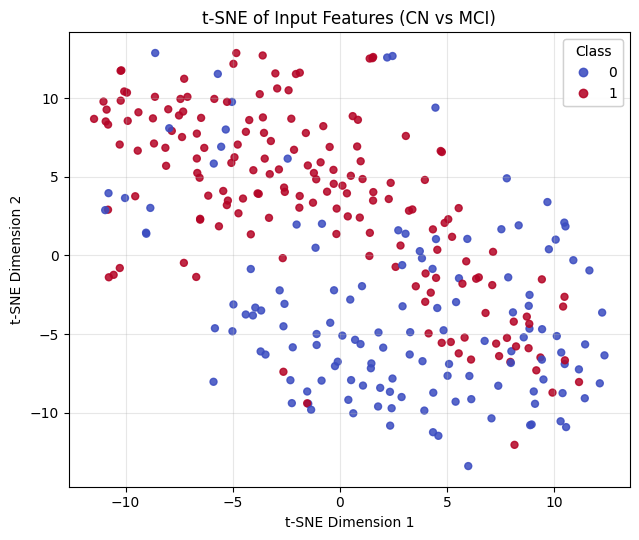

In [ ]:
# ============================
# t-SNE Visualization (Input Features)
# ============================

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# ---- Input features ----
# X can be numpy or torch
if isinstance(X, torch.Tensor):
    X_input = X.cpu().numpy()
else:
    X_input = X

# ---- Labels ----
if isinstance(y, torch.Tensor):
    labels = y.cpu().numpy()
else:
    labels = y

# ---- Run t-SNE on input features ----
tsne_input = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    init="pca",
    random_state=42
)

X_2d = tsne_input.fit_transform(X_input)

# ---- Plot t-SNE (Input Space) ----
plt.figure(figsize=(6.5, 5.5))

scatter = plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=labels,
    cmap="coolwarm",
    s=25,
    alpha=0.85
)

# ---- Legend ----
legend = plt.legend(
    *scatter.legend_elements(),
    title="Class",
    loc="best"
)
plt.gca().add_artist(legend)

# ---- Formatting ----
plt.title("t-SNE of Input Features (CN vs MCI)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


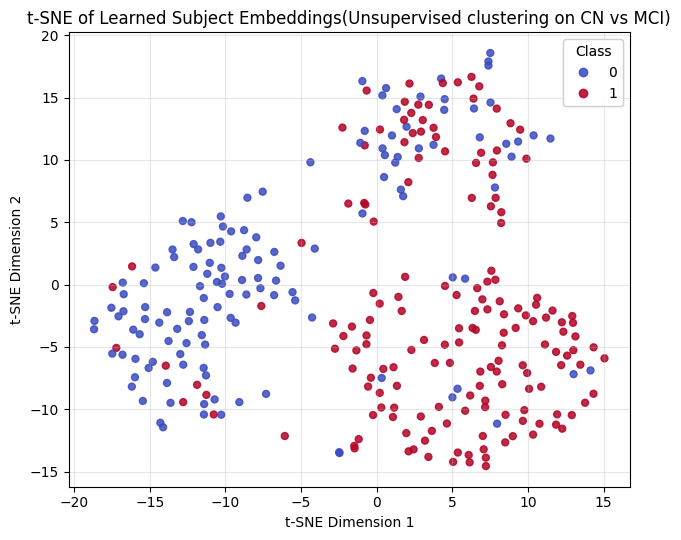

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import torch

# ---- Ensure model is in eval mode ----
model.eval()

# ---- Extract embeddings from full graph ----
with torch.no_grad():
    embeddings = model.online_encoder(data0)   # shape: [N, hidden_dim]
    embeddings = embeddings.cpu().numpy()

# ---- Convert labels to numpy ----
if isinstance(y, torch.Tensor):
    labels = y.cpu().numpy()
else:
    labels = y

# ---- Run t-SNE ----
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    # n_iter=1000, # Removed n_iter as it seems to be causing an error
    init="pca",
    random_state=42
)

embeddings_2d = tsne.fit_transform(embeddings)

# ---- Plot t-SNE ----
plt.figure(figsize=(6.5, 5.5))

scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=labels,
    cmap="coolwarm",
    s=25,
    alpha=0.85
)

# ---- Legend ----
legend = plt.legend(
    *scatter.legend_elements(),
    title="Class",
    loc="best"
)
plt.gca().add_artist(legend)

# ---- Formatting ----
plt.title("t-SNE of Learned Subject Embeddings(Unsupervised clustering on CN vs MCI)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()